In [1]:
import pyodbc
import pandas as pd

# Database connection details
driver_name = 'SQL SERVER'
server_name = 'DESKTOP-IJUSS6H'
database_name = 'Northwind'

# Connection string
connection_string = f"""
    Driver={{{driver_name}}};
    Server={{{server_name}}};
    Database={{{database_name}}};
    Trusted_Connection=yes;
"""

# Establish a connection
try:
    connection = pyodbc.connect(connection_string)
except pyodbc.Error as e:
    print(f"Error connecting to the database: {str(e)}")
    exit()

# Create a cursor
cursor = connection.cursor()

# SQL Query
query = "SELECT * FROM Northwind.dbo.TotalSalesTable;"

# Execute the query
try:
    cursor.execute(query)
except pyodbc.Error as e:
    print(f"Error executing the query: {str(e)}")
    connection.close()
    exit()

# Fetch the results into a DataFrame
try:
    results = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    df = pd.DataFrame.from_records(results, columns=column_names)
    print("Data read into DataFrame successfully.")
    print(df.head())  # Display the first few rows of the DataFrame
except pyodbc.Error as e:
    print(f"Error fetching results into DataFrame: {str(e)}")

# Close the connection
connection.close()


Data read into DataFrame successfully.
   OrderID CustomerID  Quantity UnitPrice  Discount  OrderDate  Country  \
0    10248      VINET         5   34.8000       0.0 1996-07-04   France   
1    10248      VINET        10    9.8000       0.0 1996-07-04   France   
2    10248      VINET        12   14.0000       0.0 1996-07-04   France   
3    10249      TOMSP         9   18.6000       0.0 1996-07-05  Germany   
4    10249      TOMSP        40   42.4000       0.0 1996-07-05  Germany   

                 CompanyName TotalSales  
0  Vins et alcools Chevalier   174.0000  
1  Vins et alcools Chevalier    98.0000  
2  Vins et alcools Chevalier   168.0000  
3        Toms SpezialitÃ¤ten   167.4000  
4        Toms SpezialitÃ¤ten  1696.0000  


In [2]:
df.count()

OrderID        2155
CustomerID     2155
Quantity       2155
UnitPrice      2155
Discount       2155
OrderDate      2155
Country        2155
CompanyName    2155
TotalSales     2155
dtype: int64

In [3]:
df.isna().sum()

OrderID        0
CustomerID     0
Quantity       0
UnitPrice      0
Discount       0
OrderDate      0
Country        0
CompanyName    0
TotalSales     0
dtype: int64

In [4]:
import datetime as dt

In [5]:
df['OrderDate'].max()

Timestamp('1998-05-06 00:00:00')

In [6]:
today = dt.datetime(1998,12,11)
today

datetime.datetime(1998, 12, 11, 0, 0)

In [7]:
rfm = df.groupby('CustomerID').agg({'OrderDate':lambda date:(today-date.max()).days,
                                   'OrderID' : lambda num : num.nunique(),
                                    'TotalSales' :lambda TotalSales:TotalSales.sum()
                                   })

In [8]:
 rfm

,OrderDate,OrderID,TotalSales
CustomerID,,,
ALFKI,246,6,4273.0000
ANATR,282,4,1402.9500
ANTON,317,7,7023.9800
AROUT,245,13,13390.6500
BERGS,282,18,24927.5800
...,...,...,...
WARTH,240,15,15648.7000
WELLI,277,9,6068.2000
WHITC,224,14,27363.6100


In [9]:
rfm.columns=['Recency','Frequency','Monetary']
rfm

,Recency,Frequency,Monetary
CustomerID,,,
ALFKI,246,6,4273.0000
ANATR,282,4,1402.9500
ANTON,317,7,7023.9800
AROUT,245,13,13390.6500
BERGS,282,18,24927.5800
...,...,...,...
WARTH,240,15,15648.7000
WELLI,277,9,6068.2000
WHITC,224,14,27363.6100


In [10]:
rfm = rfm[rfm["Monetary"]>0]

In [11]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
ALFKI,246,6,4273.0000
ANATR,282,4,1402.9500
ANTON,317,7,7023.9800
AROUT,245,13,13390.6500
BERGS,282,18,24927.5800
...,...,...,...
WARTH,240,15,15648.7000
WELLI,277,9,6068.2000
WHITC,224,14,27363.6100


In [12]:
rfm['Monetary'] = rfm['Monetary'].astype('int64')


In [13]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,89.0,270.561798,87.484278,219.0,227.0,242.0,277.0,876.0
Frequency,89.0,9.325843,5.810991,1.0,5.0,8.0,12.0,31.0
Monetary,89.0,14221.921348,20219.743272,100.0,3239.0,7048.0,16817.0,110277.0


In [14]:
# Assuming rfm is a DataFrame with columns 'Recency', 'Frequency', and 'Monetary'

# Create recency_score
rfm.loc[:, 'recency_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# Create frequency_score
rfm.loc[:, 'frequency_score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Create monetary_score
rfm.loc[:, 'monetary_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Display the resulting DataFrame
print(rfm.head())

            Recency  Frequency  Monetary recency_score frequency_score  \
CustomerID                                                               
ALFKI           246          6      4273             3               2   
ANATR           282          4      1402             2               1   
ANTON           317          7      7023             1               2   
AROUT           245         13     13390             3               4   
BERGS           282         18     24927             2               5   

           monetary_score  
CustomerID                 
ALFKI                   2  
ANATR                   1  
ANTON                   3  
AROUT                   4  
BERGS                   5  


In [15]:
rfm

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score
CustomerID,,,,,,
ALFKI,246,6,4273,3,2,2
ANATR,282,4,1402,2,1,1
ANTON,317,7,7023,1,2,3
AROUT,245,13,13390,3,4,4
BERGS,282,18,24927,2,5,5
...,...,...,...,...,...,...
WARTH,240,15,15648,3,5,4
WELLI,277,9,6068,2,3,3
WHITC,224,14,27363,5,5,5


In [16]:
# Concatenate the individual scores into a new 'rfm_score' column
rfm['rfm_score'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str) + rfm['monetary_score'].astype(str)

# Display the resulting DataFrame
print(rfm.head())

            Recency  Frequency  Monetary recency_score frequency_score  \
CustomerID                                                               
ALFKI           246          6      4273             3               2   
ANATR           282          4      1402             2               1   
ANTON           317          7      7023             1               2   
AROUT           245         13     13390             3               4   
BERGS           282         18     24927             2               5   

           monetary_score rfm_score  
CustomerID                           
ALFKI                   2       322  
ANATR                   1       211  
ANTON                   3       123  
AROUT                   4       344  
BERGS                   5       255  


In [17]:
seg_map ={
    r'[1-2][1-2][1-5]':'hibermating',
    r'[1-2][3-4][1-5]':'at_Risk',
    r'[1-2]5[1-5]':'cant_loose',
    r'3[1-2][1-5]':'about_to_sleep',
    r'33[1-5]':'need_attention',
    r'[3-4][4-5][1-5]':'loyal_customer',
    r'41[1-5]':'promising',
    r'51[1-5]':'new_customers',
    r'[4-5][2-3][1-5]':'potential_loyalists',
    r'5[4-5][1-5]':'champions'
}

In [18]:
rfm['Segment']=rfm['rfm_score'].replace(seg_map,regex=True)
rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,rfm_score,Segment
CustomerID,,,,,,,,
ALFKI,246,6,4273,3,2,2,322,about_to_sleep
ANATR,282,4,1402,2,1,1,211,hibermating
ANTON,317,7,7023,1,2,3,123,hibermating
AROUT,245,13,13390,3,4,4,344,loyal_customer
BERGS,282,18,24927,2,5,5,255,cant_loose


In [19]:
rfm[['Segment', 'Recency', 'Frequency', 'Monetary']].groupby('Segment').agg(['count', 'max', 'mean']).round(10)

Recency                  Frequency                 \
                      count  max        mean     count max       mean   
Segment                                                                 
about_to_sleep            5  247  245.200000         5   6   5.400000   
at_Risk                  12  407  303.416667        12  13   9.666667   
cant_loose                1  282  282.000000         1  18  18.000000   
champions                14  226  222.000000        14  31  16.071429   
hibermating              23  876  343.478261        23   7   4.000000   
loyal_customer           16  246  234.812500        16  28  14.250000   
need_attention            4  248  244.750000         4  10   8.000000   
new_customers             1  226  226.000000         1   3   3.000000   
potential_loyalists      11  234  226.818182        11  10   7.272727   
promising                 2  233  233.000000         2   5   4.500000   

                    Monetary                        
                       count     max          mean  
Segment                                             
about_to_sleep             5    5735   3872.600000  
at_Risk                   12   28872  11389.583333  
cant_loose                 1   24927  24927.000000  
champions                 14  104874  34917.928571  
hibermating               23   11666   3076.173913  
loyal_customer            16  110277  25821.062500  
need_attention             4    9736   5811.000000  
new_customers              1     649    649.000000  
potential_loyalists       11   16817   7447.272727  
promising                  2    3810   3116.500000

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
rfm['rfm_score'] = rfm['rfm_score'].astype(float)

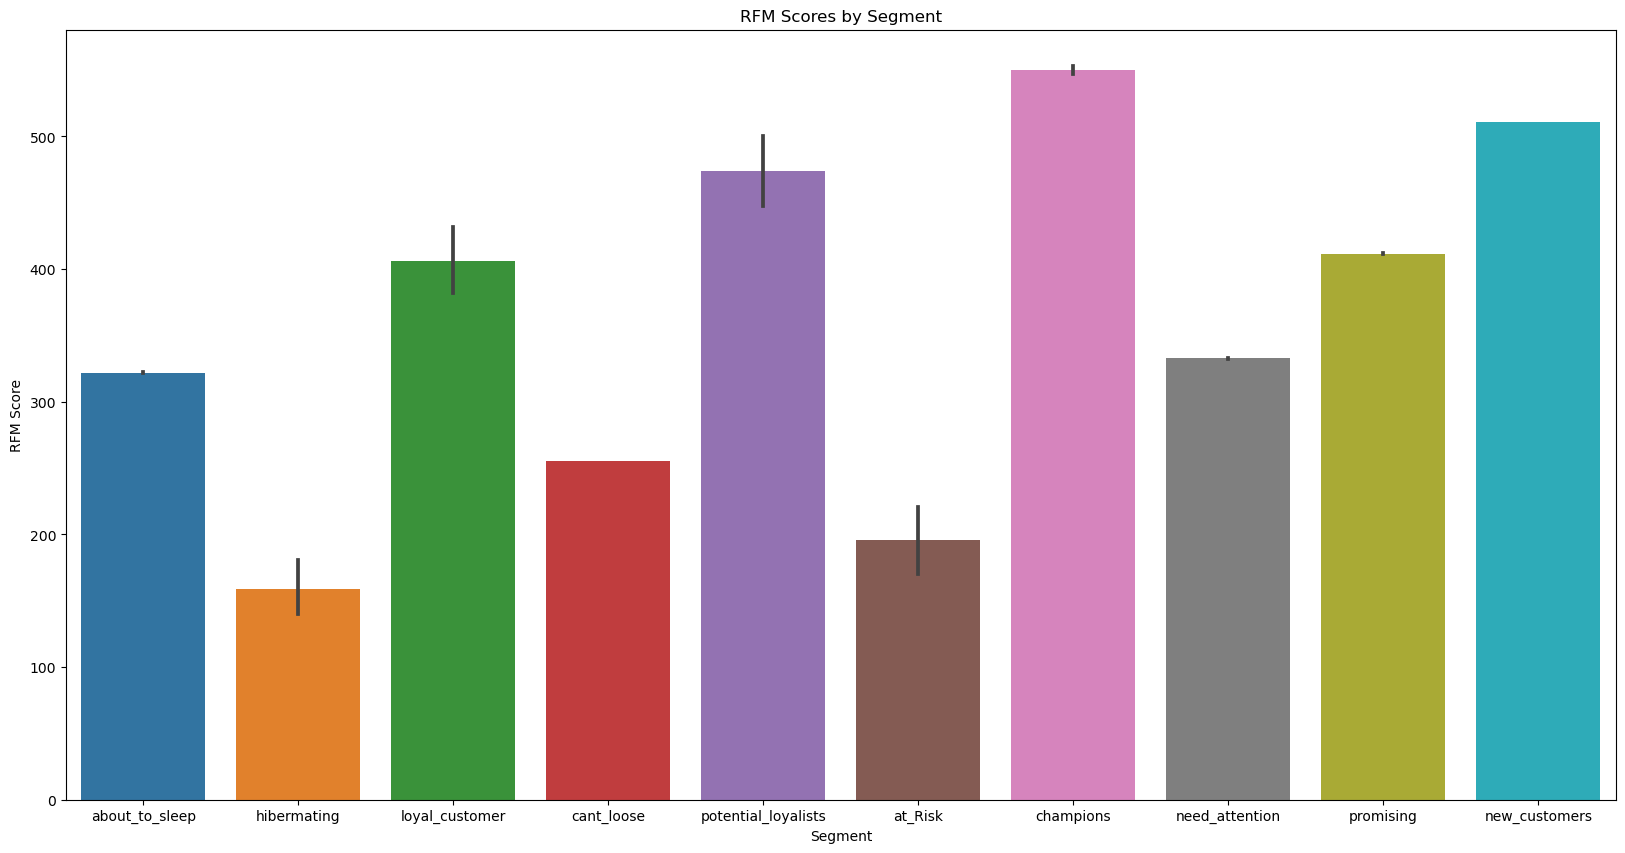

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'rfm' is your DataFrame with 'CustomerID' as the index and 'rfm_score' and 'Segment' as columns
plt.figure(figsize=(20, 10))
sns.barplot(x=rfm['Segment'], y=rfm['rfm_score'])
plt.xlabel('Segment')
plt.ylabel('RFM Score')
plt.title('RFM Scores by Segment')
plt.show()


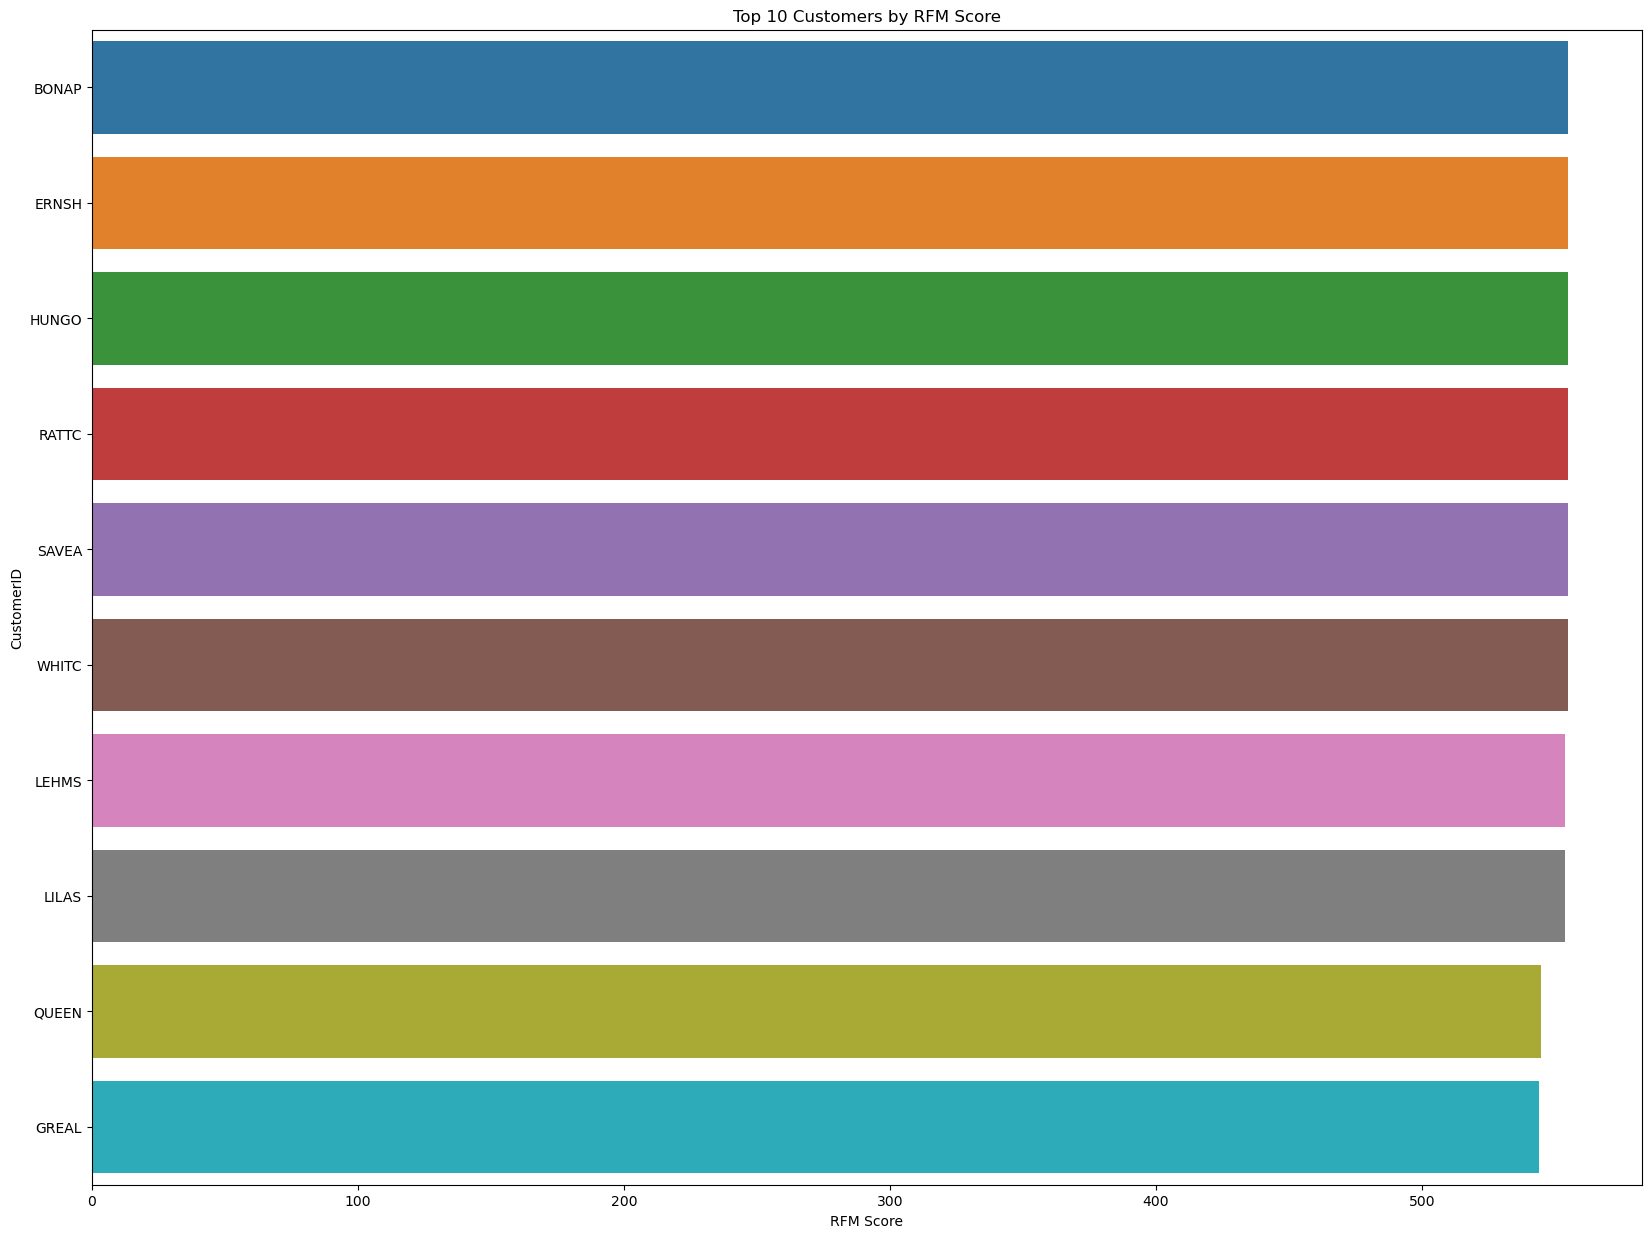

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'rfm' is your DataFrame with 'CustomerID' as the index and 'rfm_score' as a column
top_10_customers = rfm.nlargest(10, 'rfm_score')

# Create a bar plot
plt.figure(figsize=(20, 15))
sns.barplot(x=top_10_customers['rfm_score'], y=top_10_customers.index )
plt.xlabel('RFM Score')
plt.ylabel('CustomerID')
plt.title('Top 10 Customers by RFM Score')
plt.show()

